REF: https://goldcopd.org/wp-content/uploads/2020/03/GOLD-2020-POCKET-GUIDE-ver1.0_FINAL-WMV.pdf
Need to get PFT date difference

exposure and lung function decline

PCA and cluster
- only exposure
    - SO2 TO PM25
    - PCA and K-means -> weights
- All

Correlation:
- PM PCs and exposure vs all PFT changes
- Highlight significant correlated PFT values and T0 and T1

Scatterplot for FEV1, FEV1/FVC, and highly correlated with PM exposure

FEV1/FVC post < 0.7
FEV1/FVC post >=0.7 Gold0
Grade classification 

Find out decreased PFT variables and highlight
compute 1 year change of all PFT variables

Random Forest
- all %pred post 




Correlation between 
- all averaged PM variables and changes in PFT
- changes in PFT and baseline PFT

In [202]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from sklearn.cluster import KMeans
from utility import K_means, PCA_2, swap_col, show_cor_heatmap, show_cor_symmetric_heatmap

sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Add Gold Grade to df_raw

In [203]:
SUBJID = 'SUBJID.v1'
DATA_PATH = '/home/twkim/datascience/sample_df.csv'
ROOT_PATH = '/home/twkim/datascience/'

data_path = DATA_PATH

df_raw = pd.read_csv(data_path)
v1_column_list = [column for column in df_raw.columns.values if '.v1' in column]
df = df_raw[v1_column_list]
df = pd.merge(df.iloc[:50,:],df.iloc[51:,:],how='outer')

subj_id = df[SUBJID]
print('# of subjects: ' + str(len(subj_id)))

df

# of subjects: 137


,SUBJID.v1,PCT_POST_FEV1.v1,PCT_POST_FEV1FVC.v1,RDS29.v1,GOLD_Stage.v1,severity.v1,shape_TLC.v1,Vent_UML.v1,Vent_LUL.v1,Vent_LLL.v1,Vent_RUL.v1,Vent_RML.v1,Vent_RLL.v1,TLC_tissue_Total.v1,TLC_tissue_LUL.v1,TLC_tissue_LLL.v1,TLC_tissue_RUL.v1,TLC_tissue_RML.v1,TLC_tissue_RLL.v1,Emph_Total.v1,Emph_LUL.v1,Emph_LLL.v1,Emph_RUL.v1,Emph_RML.v1,Emph_RLL.v1,fSAD_Total.v1,fSAD_LUL.v1,fSAD_LLL.v1,fSAD_RUL.v1,fSAD_RML.v1,fSAD_RLL.v1,J_Total.v1,J_LUL.v1,J_LLL.v1,J_RUL.v1,J_RML.v1,J_RLL.v1,ADI_Total.v1,ADI_LUL.v1,ADI_LLL.v1,ADI_RUL.v1,ADI_RML.v1,ADI_RLL.v1,Angle_Trachea.v1,Angle_RMB.v1,Cr_Trachea.v1,Cr_RMB.v1,Cr_LMB.v1,Cr_TriLLB.v1,Cr_Bronint.v1,Cr_sLUL.v1,Cr_sLLL.v1,Cr_sRUL.v1,Cr_sRML.v1,Cr_sRLL.v1,WT_norm_Trachea.v1,WT_norm_RMB.v1,WT_norm_LMB.v1,WT_norm_TriLLB.v1,WT_norm_Bronint.v1,WT_norm_sLUL.v1,WT_norm_sLLL.v1,WT_norm_sRUL.v1,WT_norm_sRML.v1,WT_norm_sRLL.v1,Dh_norm_Trachea.v1,Dh_norm_RMB.v1,Dh_norm_LMB.v1,Dh_norm_TriLLB.v1,Dh_norm_Bronint.v1,Dh_norm_sLUL.v1,Dh_norm_sLLL.v1,Dh_norm_sRUL.v1,Dh_norm_sRML.v1,Dh_norm_sRLL.v1
0,SF181359,97.388867,95.882714,1,0,1,1.486176,0.445492,0.1535,0.3048,0.1547,0.05942,0.3276,0.134597,0.134597,0.138389,0.136493,0.109005,0.133649,0.006368,0.004459,0.004892,0.004387,0.024122,0.005740,0.038010,0.032115,0.006631,0.043976,0.253511,0.009826,1.676070,1.458174,1.888609,1.405359,1.506316,1.996976,0.417691,0.289073,0.504835,0.232768,0.945378,0.507851,11.758,7.8614,0.981363,0.966482,0.982744,0.980659,0.961749,0.957336,0.959146,0.967257,0.953408,0.966398,1.064798,0.853942,0.855878,0.728539,0.763661,0.556268,0.662959,0.651428,0.564171,0.615275,1.031637,0.806395,0.716452,0.453688,0.610203,0.226791,0.324431,0.302149,0.238732,0.294374
1,LA191699,85.699625,94.543024,1,0,1,1.623192,0.453700,0.1507,0.3653,0.1614,0.03450,0.2881,0.153555,0.151659,0.158294,0.153555,0.152607,0.150711,0.006207,0.005633,0.005044,0.009220,0.005616,0.005379,0.144650,0.173136,0.076342,0.159653,0.237142,0.154844,1.123161,1.084368,1.228001,1.090056,1.113390,1.136275,0.154163,0.122645,0.229850,0.103930,0.336145,0.171174,77.962,76.6280,0.991551,0.979170,0.982127,0.991287,0.930363,0.966863,0.974969,0.962576,0.953823,0.971809,1.067430,1.045124,1.099024,0.768337,0.683582,0.563247,0.622169,0.623467,0.621457,0.589335,1.181109,0.953407,0.846067,0.622304,0.644470,0.242648,0.370835,0.331107,0.298610,0.315627
2,LA191364,100.308060,86.592960,1,1,2,1.758470,0.420449,0.1417,0.2949,0.1543,0.06341,0.3457,0.110901,0.109005,0.112796,0.110901,0.100474,0.111848,0.004651,0.002689,0.007807,0.005602,0.005430,0.002199,0.109648,0.230592,0.063839,0.098575,0.233971,0.029841,1.697999,1.374153,1.819562,1.503067,1.544543,2.171749,0.404022,0.329199,0.427442,0.317775,0.498757,0.457017,86.601,102.3100,0.987497,0.985259,0.982673,0.979522,0.936336,0.965217,0.958774,0.920459,0.954162,0.967261,0.974872,0.896970,1.037477,0.613070,0.648701,0.570521,0.582649,0.649756,0.560840,0.562758,1.115176,0.893377,0.740115,0.507967,0.626189,0.277739,0.357393,0.446382,0.263020,0.299244
3,JH113743,71.023396,83.408816,1,2,2,1.410526,0.603878,0.2014,0.2781,0.1751,0.06547,0.2799,0.108057,0.102370,0.109005,0.116588,0.106161,0.107109,0.011137,0.017335,0.008193,0.011852,0.007553,0.009241,0.137624,0.233691,0.062872,0.117104,0.224161,0.111665,1.673118,1.541649,1.776736,1.587439,1.440680,1.928958,0.528947,0.402377,0.560150,0.440710,0.849101,0.644173,79.831,101.8500,0.995918,0.971805,0.985517,0.977248,0.922739,0.965424,0.968923,0.963215,0.969046,0.964231,1.052279,0.754775,0.756296,0.742317,0.650286,0.606775,0.616634,0.596694,0.584894,0.572852,1.115972,0.779696,0.744930,0.556174,0.592569,0.272997,0.318931,0.251468,0.275119,0.248692
4,WF122769,82.234688,101.324743,1,0,1,1.218462,0.623306,0.2256,0.2751,0.1584,0.06547,0.2755,0.183886,0.181043,0.187678,0.184834,0.164929,0.189573,0.002537,0.003076,0.002892,0.001459,0.003358,0.002247,0.000984,0.001473,0.000430,0.000745,0.004370,0.000154,2.077739,2.009872,2.440211,1.715175,1.650622,2.231155,0.338372,0.335867,0.375789,0.301720,0.402528,0.319004,78.320,9.2711,0.982399,0

## PCA & K-means for v1 variables

In [204]:
v1_variables = df.columns[1:].values
fu01 = df.iloc[:, 1:]
x_fu01 = df.iloc[:, 1:].values
PCs, weights = PCA_2(fu01)

PC1_fu01 = PCs.iloc[:,0].values
PC2_fu01 = PCs.iloc[:,1].values

PC_weights_fu01 = pd.DataFrame(weights, columns=v1_variables, index=['PC1', 'PC2'])
PC_weights_fu01

,PCT_POST_FEV1.v1,PCT_POST_FEV1FVC.v1,RDS29.v1,GOLD_Stage.v1,severity.v1,shape_TLC.v1,Vent_UML.v1,Vent_LUL.v1,Vent_LLL.v1,Vent_RUL.v1,Vent_RML.v1,Vent_RLL.v1,TLC_tissue_Total.v1,TLC_tissue_LUL.v1,TLC_tissue_LLL.v1,TLC_tissue_RUL.v1,TLC_tissue_RML.v1,TLC_tissue_RLL.v1,Emph_Total.v1,Emph_LUL.v1,Emph_LLL.v1,Emph_RUL.v1,Emph_RML.v1,Emph_RLL.v1,fSAD_Total.v1,fSAD_LUL.v1,fSAD_LLL.v1,fSAD_RUL.v1,fSAD_RML.v1,fSAD_RLL.v1,J_Total.v1,J_LUL.v1,J_LLL.v1,J_RUL.v1,J_RML.v1,J_RLL.v1,ADI_Total.v1,ADI_LUL.v1,ADI_LLL.v1,ADI_RUL.v1,ADI_RML.v1,ADI_RLL.v1,Angle_Trachea.v1,Angle_RMB.v1,Cr_Trachea.v1,Cr_RMB.v1,Cr_LMB.v1,Cr_TriLLB.v1,Cr_Bronint.v1,Cr_sLUL.v1,Cr_sLLL.v1,Cr_sRUL.v1,Cr_sRML.v1,Cr_sRLL.v1,WT_norm_Trachea.v1,WT_norm_RMB.v1,WT_norm_LMB.v1,WT_norm_TriLLB.v1,WT_norm_Bronint.v1,WT_norm_sLUL.v1,WT_norm_sLLL.v1,WT_norm_sRUL.v1,WT_norm_sRML.v1,WT_norm_sRLL.v1,Dh_norm_Trachea.v1,Dh_norm_RMB.v1,Dh_norm_LMB.v1,Dh_norm_TriLLB.v1,Dh_norm_Bronint.v1,Dh_norm_sLUL.v1,Dh_norm_sLLL.v1,Dh_norm_sRUL.v1,Dh_norm_sRML.v1,Dh_norm_sRLL.v1
PC1,-0.181174,-0.175342,0.000000e+00,0.177075,0.161186,0.038314,0.009318,-0.029065,0.022566,-0.002476,0.006646,-0.038875,-0.122362,-0.114358,-0.099200,-0.119281,-0.120486,-0.104795,0.145432,0.128830,0.137105,0.111728,0.135034,0.152848,0.214247,0.204719,0.188256,0.195162,0.194161,0.191119,-0.181954,-0.173976,-0.170168,-0.172990,-0.157471,-0.175853,-0.158142,-0.154720,-0.135234,-0.151366,-0.116372,-0.143464,-0.037336,0.026315,-0.050096,-0.072613,-0.083114,-0.002615,-0.074661,-0.004832,-0.034334,0.029223,-0.036708,-0.036247,-0.021619,-0.056274,-0.040099,-0.024683,-0.022635,-0.059004,-0.080211,-0.064263,-0.055442,-0.081381,-0.056798,-0.098315,-0.092176,-0.067252,-0.095817,-0.083976,-0.123429,-0.108074,-0.083361,-0.124007
PC2,0.010222,0.089565,-8.326673e-17,-0.060824,-0.087430,-0.033220,0.066838,0.009177,-0.140427,0.006353,-0.009852,-0.056583,0.254483,0.244798,0.250018,0.229215,0.221104,0.242602,-0.145974,-0.147742,-0.166334,-0.104909,-0.110938,-0.131003,-0.006947,-0.007124,-0.026247,-0.013464,-0.006335,-0.002183,-0.196060,-0.169297,-0.200828,-0.175958,-0.202353,-0.202696,-0.215828,-0.181588,-0.207836,-0.170480,-0.221502,-0.204887,0.023112,0.007359,0.014935,-0.019494,0.007071,-0.017568,-0.001335,-0.060242,-0.017480,-0.037280,-0.002195,-0.035154,-0.014025,-0.006086,-0.020089,-0.004889,-0.002601,-0.021629,0.018305,0.034916,0.005481,0.020472,0.044036,0.047881,0.020754,0.034210,0.024661,0.014810,0.069627,0.048533,0.005998,0.060049


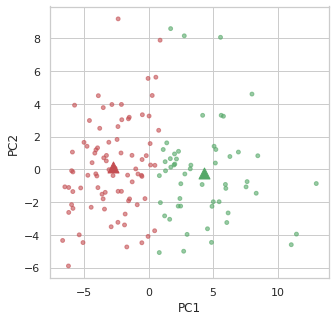

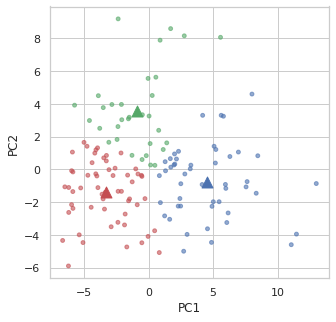

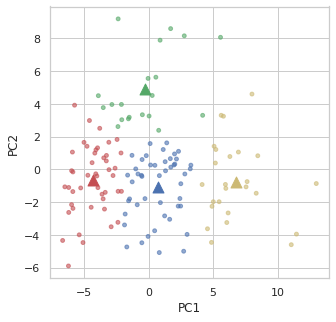

In [205]:
labels2_PC_fu01, centroids2_PC_fu01 = K_means(PC1_fu01, PC2_fu01, n=2,plot=True,xlabel='PC1',ylabel='PC2')
labels3_PC_fu01, centroids3_PC_fu01 = K_means(PC1_fu01, PC2_fu01, n=3,plot=True,xlabel='PC1',ylabel='PC2')
labels4_PC_fu01, centroids4_PC_fu01 = K_means(PC1_fu01, PC2_fu01, n=4,plot=True,xlabel='PC1',ylabel='PC2')

# Correlation: PCs

In [206]:
fu01['PC1'] = PC1_fu01
fu01['PC2'] = PC2_fu01
fu01[SUBJID] = subj_id
fu01 = swap_col(fu01)

# fu01['Cluster_PCA, k=2'] = labels2_PC_fu01
# fu01['Cluster_PCA, k=3'] = labels3_PC_fu01
# fu01['Cluster_PCA, k=4'] = labels4_PC_fu01

fu01.head()

,SUBJID.v1,PCT_POST_FEV1.v1,PCT_POST_FEV1FVC.v1,RDS29.v1,GOLD_Stage.v1,severity.v1,shape_TLC.v1,Vent_UML.v1,Vent_LUL.v1,Vent_LLL.v1,Vent_RUL.v1,Vent_RML.v1,Vent_RLL.v1,TLC_tissue_Total.v1,TLC_tissue_LUL.v1,TLC_tissue_LLL.v1,TLC_tissue_RUL.v1,TLC_tissue_RML.v1,TLC_tissue_RLL.v1,Emph_Total.v1,Emph_LUL.v1,Emph_LLL.v1,Emph_RUL.v1,Emph_RML.v1,Emph_RLL.v1,fSAD_Total.v1,fSAD_LUL.v1,fSAD_LLL.v1,fSAD_RUL.v1,fSAD_RML.v1,fSAD_RLL.v1,J_Total.v1,J_LUL.v1,J_LLL.v1,J_RUL.v1,J_RML.v1,J_RLL.v1,ADI_Total.v1,ADI_LUL.v1,ADI_LLL.v1,ADI_RUL.v1,ADI_RML.v1,ADI_RLL.v1,Angle_Trachea.v1,Angle_RMB.v1,Cr_Trachea.v1,Cr_RMB.v1,Cr_LMB.v1,Cr_TriLLB.v1,Cr_Bronint.v1,Cr_sLUL.v1,Cr_sLLL.v1,Cr_sRUL.v1,Cr_sRML.v1,Cr_sRLL.v1,WT_norm_Trachea.v1,WT_norm_RMB.v1,WT_norm_LMB.v1,WT_norm_TriLLB.v1,WT_norm_Bronint.v1,WT_norm_sLUL.v1,WT_norm_sLLL.v1,WT_norm_sRUL.v1,WT_norm_sRML.v1,WT_norm_sRLL.v1,Dh_norm_Trachea.v1,Dh_norm_RMB.v1,Dh_norm_LMB.v1,Dh_norm_TriLLB.v1,Dh_norm_Bronint.v1,Dh_norm_sLUL.v1,Dh_norm_sLLL.v1,Dh_norm_sRUL.v1,Dh_norm_sRML.v1,Dh_norm_sRLL.v1,PC1,PC2
0,SF181359,97.388867,95.882714,1,0,1,1.486176,0.445492,0.1535,0.3048,0.1547,0.05942,0.3276,0.134597,0.134597,0.138389,0.136493,0.109005,0.133649,0.006368,0.004459,0.004892,0.004387,0.024122,0.005740,0.038010,0.032115,0.006631,0.043976,0.253511,0.009826,1.676070,1.458174,1.888609,1.405359,1.506316,1.996976,0.417691,0.289073,0.504835,0.232768,0.945378,0.507851,11.758,7.8614,0.981363,0.966482,0.982744,0.980659,0.961749,0.957336,0.959146,0.967257,0.953408,0.966398,1.064798,0.853942,0.855878,0.728539,0.763661,0.556268,0.662959,0.651428,0.564171,0.615275,1.031637,0.806395,0.716452,0.453688,0.610203,0.226791,0.324431,0.302149,0.238732,0.294374,-2.608784,0.073058
1,LA191699,85.699625,94.543024,1,0,1,1.623192,0.453700,0.1507,0.3653,0.1614,0.03450,0.2881,0.153555,0.151659,0.158294,0.153555,0.152607,0.150711,0.006207,0.005633,0.005044,0.009220,0.005616,0.005379,0.144650,0.173136,0.076342,0.159653,0.237142,0.154844,1.123161,1.084368,1.228001,1.090056,1.113390,1.136275,0.154163,0.122645,0.229850,0.103930,0.336145,0.171174,77.962,76.6280,0.991551,0.979170,0.982127,0.991287,0.930363,0.966863,0.974969,0.962576,0.953823,0.971809,1.067430,1.045124,1.099024,0.768337,0.683582,0.563247,0.622169,0.623467,0.621457,0.589335,1.181109,0.953407,0.846067,0.622304,0.644470,0.242648,0.370835,0.331107,0.298610,0.315627,-0.048128,5.560575
2,LA191364,100.308060,86.592960,1,1,2,1.758470,0.420449,0.1417,0.2949,0.1543,0.06341,0.3457,0.110901,0.109005,0.112796,0.110901,0.100474,0.111848,0.004651,0.002689,0.007807,0.005602,0.005430,0.002199,0.109648,0.230592,0.063839,0.098575,0.233971,0.029841,1.697999,1.374153,1.819562,1.503067,1.544543,2.171749,0.404022,0.329199,0.427442,0.317775,0.498757,0.457017,86.601,102.3100,0.987497,0.985259,0.982673,0.979522,0.936336,0.965217,0.958774,0.920459,0.954162,0.967261,0.974872,0.896970,1.037477,0.613070,0.648701,0.570521,0.582649,0.649756,0.560840,0.562758,1.115176,0.893377,0.740115,0.507967,0.626189,0.277739,0.357393,0.446382,0.263020,0.299244,-1.635110,-0.352259
3,JH113743,71.023396,83.408816,1,2,2,1.410526,0.603878,0.2014,0.2781,0.1751,0.06547,0.2799,0.108057,0.102370,0.109005,0.116588,0.106161,0.107109,0.011137,0.017335,0.008193,0.011852,0.007553,0.009241,0.137624,0.233691,0.062872,0.117104,0.224161,0.111665,1.673118,1.541649,1.776736,1.587439,1.440680,1.928958,0.528947,0.402377,0.560150,0.440710,0.849101,0.644173,79.831,101.8500,0.995918,0.971805,0.985517,0.977248,0.922739,0.965424,0.968923,0.963215,0.969046,0.964231,1.052279,0.754775,0.756296,0.742317,0.650286,0.606775,0.616634,0.596694,0.584894,0.572852,1.115972,0.779696,0.744930,0.556174,0.592569,0.272997,0.318931,0.251468,0.275119,0.248692,-0.889339,-2.162552
4,WF122769,82.234688,101.324743,1,0,1,1.218462,0.623306,0.2256,0.2751,0.1584,0.06547,0.2755,0.183886,0.181043,0.187678,0.184834,0.164929,0.189573,0.002537,0.003076,0.002892,0.001459,0.003358,0.002247,0.000984,0.001473,0.000430,0.000745,0.004370,0.000154,2.077739,2.009872,2.440211,1.715175,1.650622,2

In [207]:
p_corr.to_csv('path',index=False)

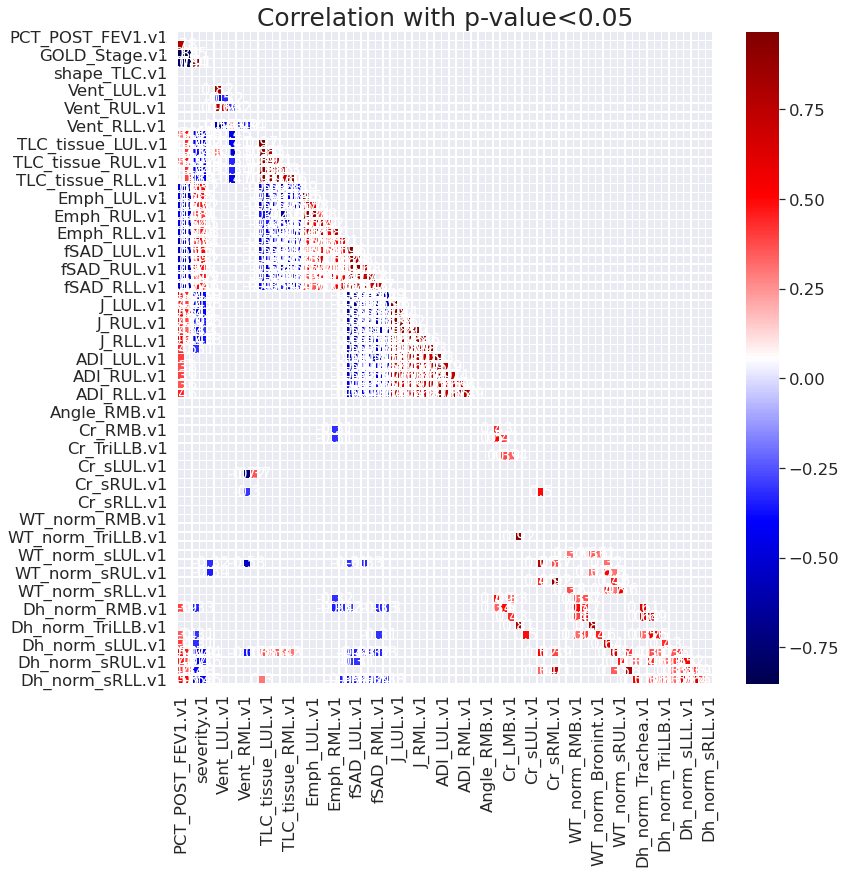

In [209]:
# Pearson
p_corr_v1 = fu01.corr(method='pearson')
PCA_columns = p_corr_v1.columns[:-2]
v1_columns = p_corr_v1.columns[-2:]
p_corr, p_values = show_cor_symmetric_heatmap(p_corr_v1,43,v1_columns,v1_columns)

In [187]:
p_corr

,PCT_POST_FEV1.v1,PCT_POST_FEV1FVC.v1,GOLD_Stage.v1,severity.v1,shape_TLC.v1,Vent_UML.v1,Vent_LUL.v1,Vent_LLL.v1,Vent_RUL.v1,Vent_RML.v1,Vent_RLL.v1,TLC_tissue_Total.v1,TLC_tissue_LUL.v1,TLC_tissue_LLL.v1,TLC_tissue_RUL.v1,TLC_tissue_RML.v1,TLC_tissue_RLL.v1,Emph_Total.v1,Emph_LUL.v1,Emph_LLL.v1,Emph_RUL.v1,Emph_RML.v1,Emph_RLL.v1,fSAD_Total.v1,fSAD_LUL.v1,fSAD_LLL.v1,fSAD_RUL.v1,fSAD_RML.v1,fSAD_RLL.v1,J_Total.v1,J_LUL.v1,J_LLL.v1,J_RUL.v1,J_RML.v1,J_RLL.v1,ADI_Total.v1,ADI_LUL.v1,ADI_LLL.v1,ADI_RUL.v1,ADI_RML.v1,ADI_RLL.v1,Angle_Trachea.v1,Angle_RMB.v1,Cr_Trachea.v1,Cr_RMB.v1,Cr_LMB.v1,Cr_TriLLB.v1,Cr_Bronint.v1,Cr_sLUL.v1,Cr_sLLL.v1,Cr_sRUL.v1,Cr_sRML.v1,Cr_sRLL.v1,WT_norm_Trachea.v1,WT_norm_RMB.v1,WT_norm_LMB.v1,WT_norm_TriLLB.v1,WT_norm_Bronint.v1,WT_norm_sLUL.v1,WT_norm_sLLL.v1,WT_norm_sRUL.v1,WT_norm_sRML.v1,WT_norm_sRLL.v1,Dh_norm_Trachea.v1,Dh_norm_RMB.v1,Dh_norm_LMB.v1,Dh_norm_TriLLB.v1,Dh_norm_Bronint.v1,Dh_norm_sLUL.v1,Dh_norm_sLLL.v1,Dh_norm_sRUL.v1,Dh_norm_sRML.v1,Dh_norm_sRLL.v1
PCT_POST_FEV1.v1,1.000000,0.783808,-0.840976,-0.737864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.305983,NaN,NaN,0.314758,NaN,NaN,-0.521067,-0.470228,-0.472256,-0.406826,-0.453879,-0.486084,-0.563927,-0.513595,-0.539352,-0.491550,-0.456107,-0.522983,0.550266,0.473809,0.553705,0.471692,0.448069,0.596627,0.445151,0.395593,0.375661,0.394243,0.355846,0.458607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.392794,NaN,NaN,0.344719,0.403744,0.540387,0.479469,0.403009,0.581898
PCT_POST_FEV1FVC.v1,0.783808,1.000000,-0.852222,-0.838638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.480558,0.440491,0.406881,0.485384,0.434576,0.384390,-0.630610,-0.580797,-0.611707,-0.481612,-0.540192,-0.573947,-0.605658,-0.560570,-0.592186,-0.541085,-0.514696,-0.517296,0.439275,0.396264,0.437815,0.389292,0.339586,0.441395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.465527,0.366951,0.344714,0.502488
GOLD_Stage.v1,-0.840976,-0.852222,1.000000,0.914911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.444139,-0.411109,-0.381610,-0.417569,-0.414419,-0.380137,0.509375,0.475480,0.477436,0.391616,0.444922,0.486915,0.578577,0.550848,0.525538,0.527612,0.519148,0.506215,-0.488443,-0.465654,-0.478486,-0.440771,-0.387968,-0.480113,-0.314413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.332977,NaN,NaN,-0.305265,-0.312229,-0.491479,-0.404104,-0.376673,-0.534084
severity.v1,-0.737864,-0.838638,0.914911,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.463608,-0.422669,-0.406310,-0.440260,-0.433728,-0.404605,0.520534,0.497199,0.524503,0.400769,0.450937,0.478945,0.536235,0.501452,0.517539,0.495404,0.490150,0.457901,-0.393214,-0.380616,-0.402260,-0.358152,-0.303180,-0.375830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.440072,-0.364164,NaN,-0.445222
shape_TLC.v1,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.316036,-0.342990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Dh_norm_sLUL.v1,0.403744,NaN,-0.312229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.641268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.433299,NaN,1.000000,0.407024,0.533574,0.338117,0.563424
Dh_norm_sLLL.v1,0.540387,0.465527,-0.491479,-0

In [210]:
p_corr.to_csv(ROOT_PATH + 'output_p_corr.csv')
p_values.to_csv(ROOT_PATH + 'output_p_values.csv')